In [1]:
from fonctions import *


In [2]:
# ---------------------------------------
# 1. Chargement et préprocessing des données
# ---------------------------------------
train_df = pd.read_csv("train.csv", sep="\t")


In [3]:
# Sélection des colonnes quantitatives
num_cols = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]

X = train_df[num_cols].values
y = train_df["playlist_genre"].values


In [4]:
# Encodage manuel des labels
unique_genres = np.unique(y)
genre_to_idx = {g: i for i, g in enumerate(unique_genres)}
y_encoded = np.array([genre_to_idx[g] for g in y])

num_classes = len(unique_genres)


In [5]:
# Normalisation (Standardisation)
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / (std + 1e-8)


In [6]:
# Séparation Train/Val/Test
# 70% train, 15% val, 15% test
n = len(X)
idx = np.arange(n)
np.random.shuffle(idx)
X = X[idx]
y_encoded = y_encoded[idx]

train_size = int(0.7 * n)
val_size = int(0.15 * n)
test_size = n - train_size - val_size

X_train = X[:train_size]
y_train = y_encoded[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y_encoded[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y_encoded[train_size + val_size :]


In [7]:
# ---------------------------------------
# 5. Boucle d'expérimentation sur plusieurs hyperparamètres
# ---------------------------------------
layer_configs = [
    [],
    [1],
    [4, 4],
    [2, 4, 8, 16, 32, 64, 32, 16, 8, 4, 2],
    [64],  # 1 couche cachée de 64 neurones
    [512, 512],
    [1024],  # 1 couche cachée de 128 neurones
    [64, 64],  # 2 couches cachées de 64 neurones chacune
]

batch_sizes = [32, 64, 256]
learning_rates = [0.01, 0.001, 0.0001]

results = []  # pour stocker toutes les configurations testées


In [8]:
for layers in layer_configs:
    for bs in batch_sizes:
        for lr in learning_rates:
            print(f"\nConfiguration: Layers={layers}, Batch={bs}, LR={lr}")
            model = MLP(
                input_dim=X_train.shape[1], layer_sizes=layers, num_classes=num_classes
            )
            history = train_model(
                model,
                X_train,
                y_train,
                X_val,
                y_val,
                epochs=20,
                batch_size=bs,
                lr=lr,
                verbose=False,
            )
            val_acc = history["val_acc"][-1]
            print(f"Validation Accuracy: {val_acc:.4f}")
            results.append((val_acc, layers, bs, lr, history, model))



Configuration: Layers=[], Batch=32, LR=0.01
Validation Accuracy: 0.4851

Configuration: Layers=[], Batch=32, LR=0.001
Validation Accuracy: 0.4742

Configuration: Layers=[], Batch=32, LR=0.0001
Validation Accuracy: 0.4515

Configuration: Layers=[], Batch=64, LR=0.01
Validation Accuracy: 0.4829

Configuration: Layers=[], Batch=64, LR=0.001
Validation Accuracy: 0.4723

Configuration: Layers=[], Batch=64, LR=0.0001
Validation Accuracy: 0.4421

Configuration: Layers=[], Batch=256, LR=0.01
Validation Accuracy: 0.4767

Configuration: Layers=[], Batch=256, LR=0.001
Validation Accuracy: 0.4580

Configuration: Layers=[], Batch=256, LR=0.0001
Validation Accuracy: 0.3037

Configuration: Layers=[1], Batch=32, LR=0.01
Validation Accuracy: 0.4079

Configuration: Layers=[1], Batch=32, LR=0.001
Validation Accuracy: 0.2147

Configuration: Layers=[1], Batch=32, LR=0.0001
Validation Accuracy: 0.2147

Configuration: Layers=[1], Batch=64, LR=0.01
Validation Accuracy: 0.4029

Configuration: Layers=[1], Batc

In [9]:
# ---------------------------------------
# 6. Extraction des trois meilleures configurations
# ---------------------------------------
results.sort(key=lambda x: x[0], reverse=True)
top_5 = results[:5]

print("\nTop 3 des configurations (Val Accuracy):")
for i, (val_acc, layers, bs, lr, hist, mdl) in enumerate(top_5, start=1):
    print(f"{i}) Val_Acc={val_acc:.4f}, Layers={layers}, Batch={bs}, LR={lr}")



Top 3 des configurations (Val Accuracy):
1) Val_Acc=0.5106, Layers=[1024], Batch=32, LR=0.01
2) Val_Acc=0.5081, Layers=[512, 512], Batch=32, LR=0.01
3) Val_Acc=0.4956, Layers=[1024], Batch=64, LR=0.01
4) Val_Acc=0.4944, Layers=[64], Batch=32, LR=0.01
5) Val_Acc=0.4919, Layers=[64], Batch=64, LR=0.01


In [10]:
# On va afficher les courbes pour la meilleure config (top_1)
best_val_acc, best_layers, best_bs, best_lr, best_history, best_model = top_5[0]


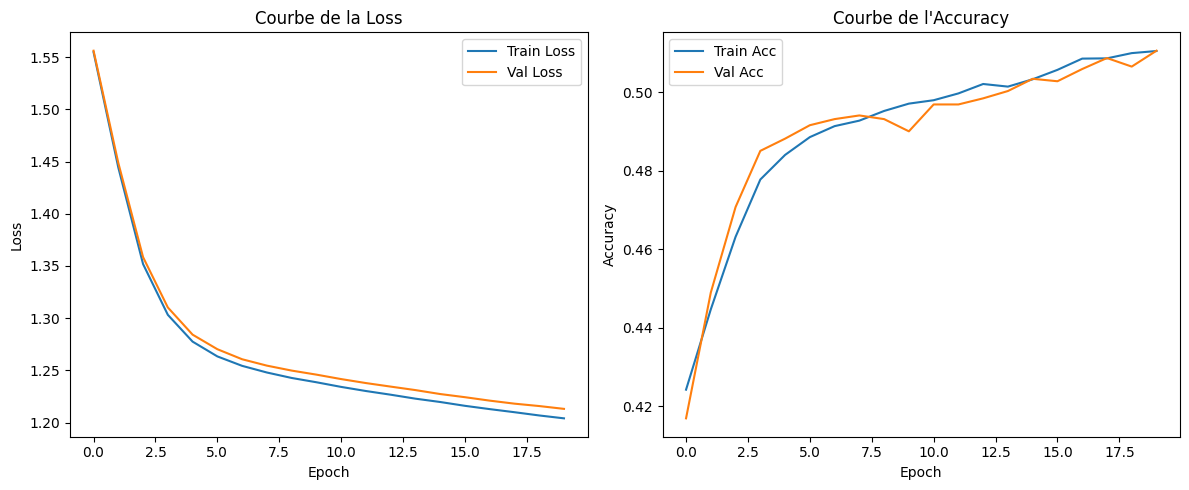

In [11]:
# ---------------------------------------
# 7. Tracés des courbes d’apprentissage pour le meilleur modèle
# ---------------------------------------
plt.figure(figsize=(12, 5))

# Courbe de la loss (gauche)
plt.subplot(1, 2, 1)
plt.plot(best_history["train_loss"], label="Train Loss")
plt.plot(best_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la Loss")
plt.legend()

# Courbe de l'accuracy (droite)
plt.subplot(1, 2, 2)
plt.plot(best_history["train_acc"], label="Train Acc")
plt.plot(best_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Courbe de l'Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Evaluation finale sur le test
test_activations = best_model.forward(X_test)[-1]
test_loss = cross_entropy_loss(test_activations, y_test)
test_acc = accuracy(test_activations, y_test)

# Affichage des résultats et des paramètres de la meilleure architecture
print(
    f"Performance sur le test set (Meilleure config) :\n"
    f"\tLoss = {test_loss:.4f}\n"
    f"\tAccuracy = {test_acc:.4f}\n"
    f"\nParamètres de la meilleure architecture :\n"
    f"\tCouches = {best_layers}\n"
    f"\tBatch Size = {best_bs}\n"
    f"\tLearning Rate = {best_lr}"
)


Performance sur le test set (Meilleure config) :
	Loss = 1.2045
	Accuracy = 0.5079

Paramètres de la meilleure architecture :
	Couches = [1024]
	Batch Size = 32
	Learning Rate = 0.01
